# Lecture 5 exercises

In [1]:
!pip install devito

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.3/589.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 6.9 MB/s eta 0:00:00
  Created wheel for cgen: filename=cgen-2020.1-py3-none-any.whl size=15822 sha256=102df93cde3635ebe137a7c4a6096cf652b505f6220d1e78c3accb763d1277cf
  Stored in directory: /root/.cache/pip/wheels/01/34/f5/22d1829ddda18b9c41750593a5b8845f86d507317100457abd
  Created wheel for codepy: filename=codepy-2023.1-py3-none-any.whl size=24870 sha256=6ea60b64f2e839f62f687c172a3daabf18bb4720fc7287f7834c28762a122813
  Stored in directory: /root/.cache/pip/wheels/50/e4/42/56224a0f1f9d2260ed7525f560a46785f90952794d17d9be2e
Successful

## Excersie 1: Comparison against exact solution 1

An exact traveling wave solution to the 1-dimensional wave-equation,
$$\frac{1}{c^2}\frac{\partial^2 u}{\partial t^2}-\frac{\partial^2 u}{\partial x^2}=0,$$
on the interval $x\in[0,1]$ with $c=1$ is given by:
$$u(x,t)=\left[\mathrm{max}(0,4\zeta(1-\zeta))\right]^{12},$$
where
$$\zeta=4(x-ct)-1,$$
subject to the boundary conditions $u(0,t)=u(1,t)=0$. Compose a Devito operator to solve this problem and check that the numerical solution returns to (approximately) the initial condition at $t=2$.

In [15]:
# Some hints:

# Additional required imports
import numpy as np
from devito import Grid, Function, TimeFunction, solve

# Python functions to compute the initial condition:
def compute_zeta(x,t):
    return 4.0*(x-t)-1.0

def compute_u(x,t):
    u1 = 4.0*compute_zeta(x,t)*(1.0-compute_zeta(x,t))
    u2 = np.zeros(u1.shape)
    return (np.maximum(u1,u2))**(12)

# define spatial mesh
# Size of rectangular domain
Lx = 1

# Number of grid points in each direction, including boundary nodes
Nx = 201

# hence the mesh spacing
dx = Lx/(Nx-1)

x = np.linspace(0,Lx,Nx)

grid = Grid(shape=(Nx), extent=(Lx))

# Initial condition
u_0 = Function(name='u_0', grid=grid)
u_0.data[:] = compute_u(x,0)

# We'll need one of these for composing the boundary conditions:
t = grid.stepping_dim
time = grid.time_dim

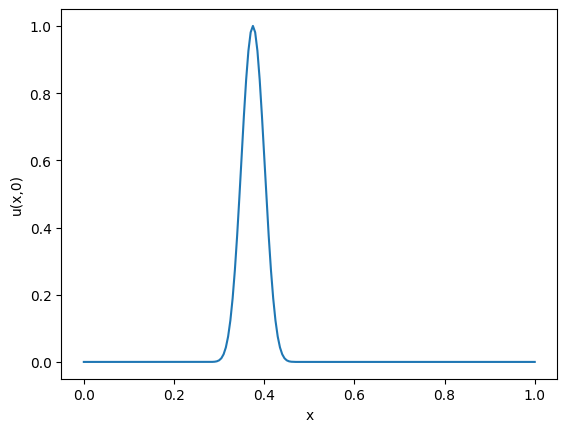

In [ ]:
# Plot the initial condition

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(x, u_0.data[:])
plt.xlabel('x')
plt.ylabel('u(x,0)')
plt.show()

In [19]:
from devito import Grid, TimeFunction, Eq, Operator

In [20]:
# Define our mesh

nx = 101  # Number of grid points in space
nt = 2000  # Number of time steps
dx = 1.0 / (nx - 1)  # Spatial step size
dt = 0.001  # Time step size (small for stability)

grid = Grid(shape=(nx,), extent=(1.0,))  # 1D grid from x=0 to x=1

In [30]:
# Define the wavefield

u = TimeFunction(name="u", grid=grid, time_order=2, space_order=2)

u(t, x)

In [25]:
# Define the IC

c = 1.0  # Wave speed

x_vals = np.linspace(0, 1, nx)  # Generate the spatial coordinates

zeta = 4 * (x_vals - 1) - 1

u.data[0, :] = np.maximum(0, 4 * zeta * (1 - zeta))**12 # For all t, assign IC

In [31]:
# Define the equation
pde = (1/c**2) * (u.dt2-u.dx2) # wave eq

stencil = solve(pde, u.forward)
eq = Eq(u.forward, stencil) # This is our FD update scheme
eq.evaluate

Eq(u(t + dt, x), dt**2*(-(-2.0*u(t, x)/dt**2 + u(t - dt, x)/dt**2) - 2.0*u(t, x)/h_x**2 + u(t, x - h_x)/h_x**2 + u(t, x + h_x)/h_x**2))

In [38]:
# Apply BCs

bc = [Eq(u[t+1, 0], 0)]
bc += [Eq(u[t+1, Nx-1], 0)]

In [39]:
# Create the Devito operator and solve
op = Operator([eq]+bc)
op.apply(time_m=1, time_M=1999, dt=dt)

Operator `Kernel` ran in 0.01 s
INFO:Devito:Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.0001439999999999997, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [34]:
import matplotlib.pyplot as plt

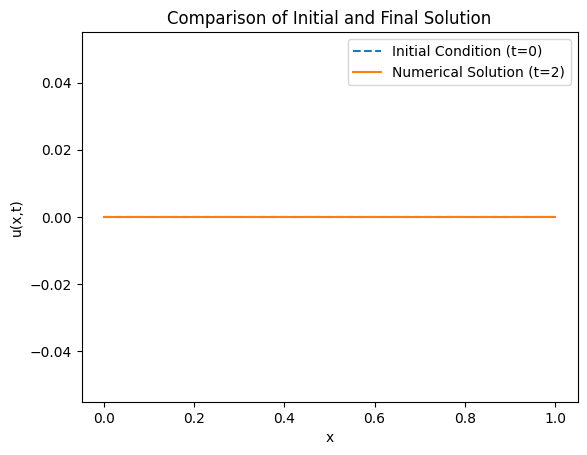

In [40]:
plt.plot(x_vals, u.data[0, :], label="Initial Condition (t=0)", linestyle="dashed")
plt.plot(x_vals, u.data[-1, :], label="Numerical Solution (t=2)")
plt.legend()
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Comparison of Initial and Final Solution")
plt.show()

#### **Hint** regarding boundary conditions:

Dirichlet boundary conditions can be set via a list of equation as, e.g., `bc=[Eq(u[t+1, 0], 0)]` and then included in an operator via `op=Operator([main_list_of_equations]+bc)`. See the linear convection example from the first notebook of lecture 10.

## Excersie 2: Comparison against exact solution 2

Consider the following boundary value problem for the 1D wave equation:

\begin{align}
  \frac{1}{c^2}\frac{\partial^2 u}{\partial t^2}(x,t)-\frac{\partial^2 u}{\partial x^2}(x,t)&=0, \\
  u(0,t)=u(10,t)&= 0, \\
  \frac{\partial u}{\partial t}(x,0)&=0, \\
  u(x,0)&=
    \begin{cases}
      0, & 0 \leq x < 4,\\
      1, & 4 \leq x \leq 6,\\
      0, & 6 < x \leq 10.
    \end{cases}
\end{align}

The initial state is illustrated in the figure below:

<img src="https://github.com/nocturnal-luke/Geophysical-inversion-undergraduate/blob/main/lectures/L5/figures/exact_solution.png?raw=1" width="450" height="450" align="center"/>

- **Show that the exact solution to this problem is:**
\begin{equation}
 u(x,t)=\sum_{n=1}^{\infty}A_{n}\sin\left(\frac{n\pi x}{10}\right)\cos\left(\frac{n\pi ct}{10}\right),
\end{equation}
where
\begin{equation}
  A_n=\frac{2}{n\pi}\left[\cos\left(\frac{4n\pi}{10}\right)-\cos\left(\frac{6n\pi}{10}\right)\right].
\end{equation}

Below is a snippet of code to plot the exact result at any point in time. You can use it to explore the evolution of the wave. Does it produce the expected behavior?

In [ ]:
from numpy import sin, cos, pi, linspace, shape, zeros, mod

import matplotlib.pyplot as plt

# Global constants
L = 10. # Define length of domain as a global variable
N = 2000 # Number of terms in the Fourier sine series
l = 1001 # Define number of points in domain
c = 1.0 # Speed of sound

x = linspace(0, L, l) # x axis for calling u(x, t) at given t

# Calculate exact solution

def u_e(x, t):
    s = zeros(x.size)
    for i in range(1,N+1):
        s+=A_n(i)*sin(i*pi*x/L)*cos(i*pi*c*t/L)
    return s

def A_n(n):
    const = 2/n/pi*(cos(4*n*pi/L)-cos(6*n*pi/L))
    return const

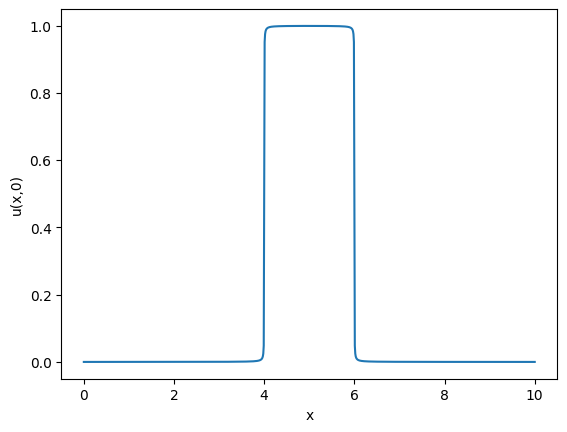

In [ ]:
%matplotlib inline
# Plot solution at a point T in time
T = 0
plt.plot(x, u_e(x, T))
plt.xlabel('x')
plt.ylabel('u(x,0)')
plt.show()

- **Can you write a finite difference code to solve the above problem?**
- **Can you now also solve the same problem using Devito?**
- **How similar is your solution to the exact solution? How do you think this result can be improved?**